### K-means

             track_id                                   user_id  playcount  \
0  TRIRLYL128F42539D1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
1  TRFUPBA128F934F7E1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
2  TRLQPQJ128F42AA94F  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
3  TRTUCUY128F92E1D24  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
4  TRHDDQG12903CB53EE  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   

   most_played_cluster  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  


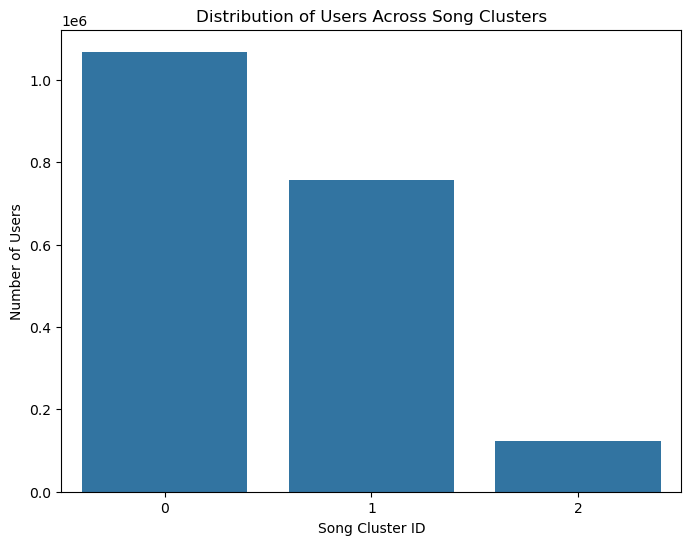

In [1]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

# Load data
file_path_users = "Data/User Listening History.csv"
df_users = pd.read_csv(file_path_users)
file_path_songs = "Data/Music Info.csv"
df_songs = pd.read_csv(file_path_songs)

# One-hot encode the 'genre' column
genre_encoded = pd.get_dummies(df_songs['genre'], prefix='genre')

# Concatenate the one-hot-encoded genre features with the rest of the numeric features
song_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 
                 'tempo', 'year']  # Exclude 'genre' here

numeric_features = df_songs[song_features]
song_data = pd.concat([genre_encoded, numeric_features], axis=1)

# Normalize the numeric and one-hot-encoded song features
scaler = StandardScaler()
scaled_songs = scaler.fit_transform(song_data)

# Apply KMeans clustering to the songs
n_song_clusters = 3  # Choose an appropriate number of clusters
kmeans_songs = KMeans(n_clusters=n_song_clusters, random_state=42)
df_songs['song_cluster'] = kmeans_songs.fit_predict(scaled_songs)

# Merge song clusters into the user data
df_users = df_users.merge(df_songs[['track_id', 'song_cluster']], on='track_id', how='left')

# Group by user and song cluster, and sum the playcount
user_cluster_plays = df_users.groupby(['user_id', 'song_cluster'])['playcount'].sum().reset_index()

# Pivot to create a matrix of users vs. song clusters
user_cluster_matrix = user_cluster_plays.pivot(index='user_id', columns='song_cluster', values='playcount').fillna(0)

# Find the song cluster with the maximum playcount for each user
user_cluster_matrix['most_played_cluster'] = user_cluster_matrix.idxmax(axis=1)

# Merge the most played cluster information back to the user data
df_users = df_users.merge(user_cluster_matrix['most_played_cluster'], on='user_id', how='left')

# Drop unnecessary columns
df_users = df_users.drop(columns=['song_cluster'], axis=1)

# Print the resulting user dataset with clusters
print(df_users.head())

# Plot the distribution of users across song clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='most_played_cluster', data=user_cluster_matrix.reset_index())
plt.title('Distribution of Users Across Song Clusters')
plt.xlabel('Song Cluster ID')
plt.ylabel('Number of Users')
plt.show()

### DBSCAN

             track_id                                   user_id  playcount  \
0  TRIRLYL128F42539D1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
1  TRFUPBA128F934F7E1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
2  TRLQPQJ128F42AA94F  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
3  TRTUCUY128F92E1D24  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
4  TRHDDQG12903CB53EE  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   

   most_played_cluster  
0                  2.0  
1                  2.0  
2                  2.0  
3                  2.0  
4                  2.0  


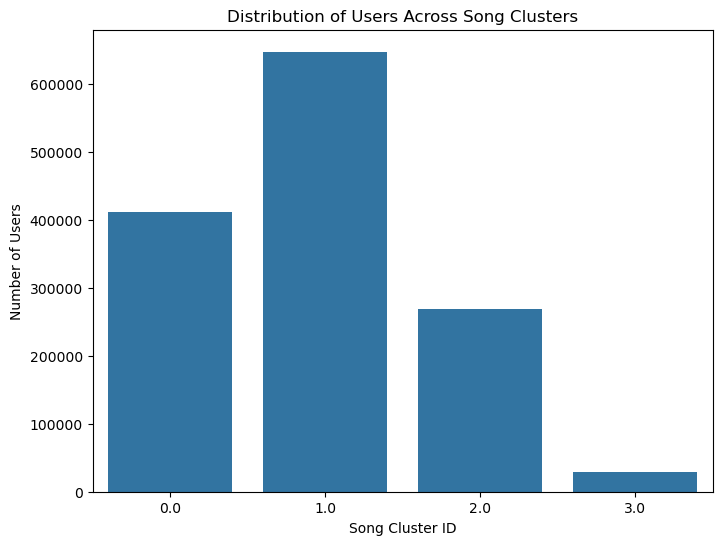

In [25]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
file_path_users = "Data/User Listening History.csv"
df_users = pd.read_csv(file_path_users)
file_path_songs = "Data/Music Info.csv"
df_songs = pd.read_csv(file_path_songs)

# --- Fix starts here ---
# One-hot encode the 'genre' column
genre_encoded = pd.get_dummies(df_songs['genre'], prefix='genre')

# Concatenate the one-hot-encoded genre features with the rest of the numeric features
song_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 
                 'tempo', 'year']  # Exclude 'genre' here

numeric_features = df_songs[song_features]
song_data = pd.concat([genre_encoded, numeric_features], axis=1)

# Normalize the numeric and one-hot-encoded song features
scaler = StandardScaler()
scaled_songs = scaler.fit_transform(song_data)
# --- Fix ends here ---

# Apply DBSCAN clustering to the songs
eps_value = 1.5  # Maximum distance for two points to be considered neighbors
min_samples_value = 100  # Minimum number of points to form a cluster
dbscan_songs = DBSCAN(eps=eps_value, min_samples=min_samples_value)
df_songs['song_cluster'] = dbscan_songs.fit_predict(scaled_songs)

# Handle noise points (label -1 in DBSCAN)
# Optional: Assign noise points to a separate cluster, or drop them if necessary
df_songs['song_cluster'] = df_songs['song_cluster'].replace(-1, np.nan)

# Merge song clusters into the user data
df_users = df_users.merge(df_songs[['track_id', 'song_cluster']], on='track_id', how='left')

# Group by user and song cluster, and sum the playcount
user_cluster_plays = df_users.groupby(['user_id', 'song_cluster'])['playcount'].sum().reset_index()

# Pivot to create a matrix of users vs. song clusters
user_cluster_matrix = user_cluster_plays.pivot(index='user_id', columns='song_cluster', values='playcount').fillna(0)

# Find the song cluster with the maximum playcount for each user
user_cluster_matrix['most_played_cluster'] = user_cluster_matrix.idxmax(axis=1)

# Merge the most played cluster information back to the user data
df_users = df_users.merge(user_cluster_matrix['most_played_cluster'], on='user_id', how='left')

# Drop unnecessary columns
df_users = df_users.drop(columns=['song_cluster'], axis=1)

# Print the resulting user dataset with clusters
print(df_users.head())

# Plot the distribution of users across song clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='most_played_cluster', data=user_cluster_matrix.reset_index())
plt.title('Distribution of Users Across Song Clusters')
plt.xlabel('Song Cluster ID')
plt.ylabel('Number of Users')
plt.show()

##### Number of users in each cluster

most_played_cluster
0    795481
2    122400
1     44156
Name: count, dtype: int64


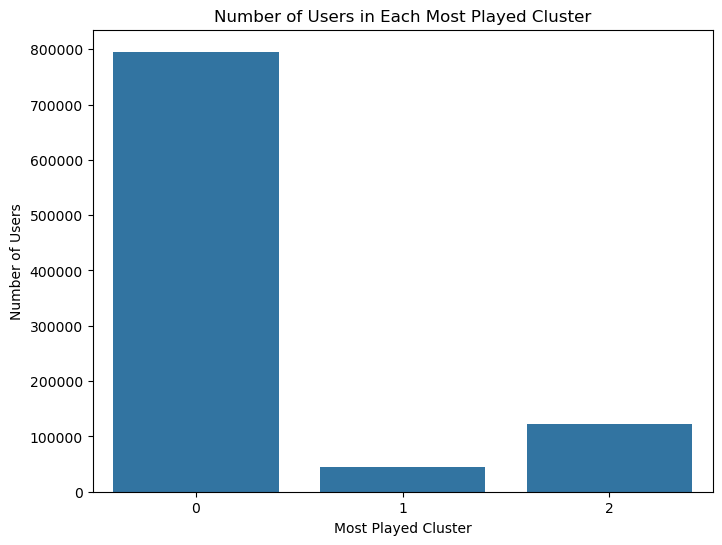

In [2]:
# Count the number of users in each most_played_cluster
cluster_counts = user_cluster_matrix['most_played_cluster'].value_counts()

# Print the results
print(cluster_counts)

# Optional: Visualize the counts with a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Number of Users in Each Most Played Cluster')
plt.xlabel('Most Played Cluster')
plt.ylabel('Number of Users')
plt.show()

##### Characteristics of the user clusters

In [4]:
# Analyze cluster characteristics
cluster_characteristics = (
    song_data.assign(song_cluster=df_songs['song_cluster'])  # Add cluster labels to the feature data
    .groupby('song_cluster')  # Group by clusters
    .mean()  # Compute mean feature values for each cluster
)

# Add genre feature relevance
genre_columns = [col for col in song_data.columns if col.startswith('genre_')]
numeric_columns = [col for col in song_data.columns if col not in genre_columns]

print("Cluster Characteristics:")
for cluster_id in range(len(cluster_characteristics)):
    print(f"\nCluster {cluster_id} Characteristics:")
    print("Top Genres (based on mean relevance):")
    top_genres = cluster_characteristics.loc[cluster_id, genre_columns].sort_values(ascending=False).head(5)
    print(top_genres)

    print("\nTop Numeric Features (based on mean values):")
    top_numeric = cluster_characteristics.loc[cluster_id, numeric_columns].sort_values(ascending=False).head(5)
    print(top_numeric)

    print("\nLowest Numeric Features (based on mean values):")
    low_numeric = cluster_characteristics.loc[cluster_id, numeric_columns].sort_values(ascending=True).head(5)
    print(low_numeric)

Cluster Characteristics:

Cluster 0 Characteristics:
Top Genres (based on mean relevance):
genre_Rock      0.227340
genre_Metal     0.067167
genre_Pop       0.025013
genre_Rap       0.021391
genre_Reggae    0.017027
Name: 0, dtype: float64

Top Numeric Features (based on mean values):
year      2004.486139
tempo      127.165476
key          5.356568
energy       0.802836
mode         0.630426
Name: 0, dtype: float64

Lowest Numeric Features (based on mean values):
loudness           -6.401730
acousticness        0.078183
speechiness         0.084212
instrumentalness    0.170957
liveness            0.231359
Name: 0, dtype: float64

Cluster 1 Characteristics:
Top Genres (based on mean relevance):
genre_Electronic    1.0
genre_Blues         0.0
genre_Country       0.0
genre_Folk          0.0
genre_Jazz          0.0
Name: 1, dtype: float64

Top Numeric Features (based on mean values):
year            2004.562569
tempo            125.873201
key                5.409041
energy             0.6

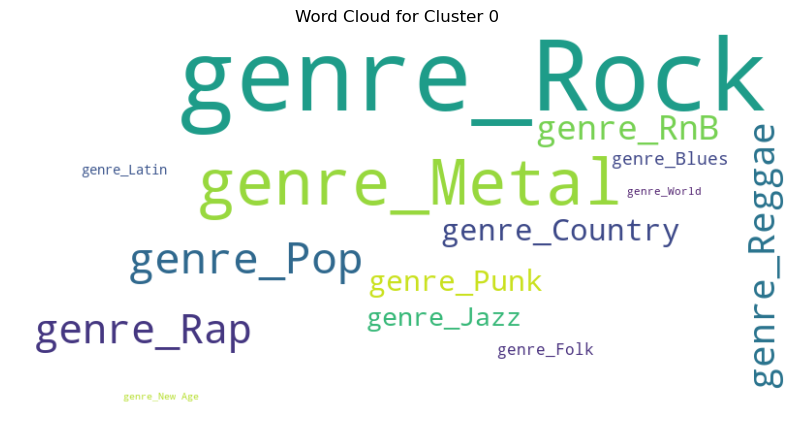

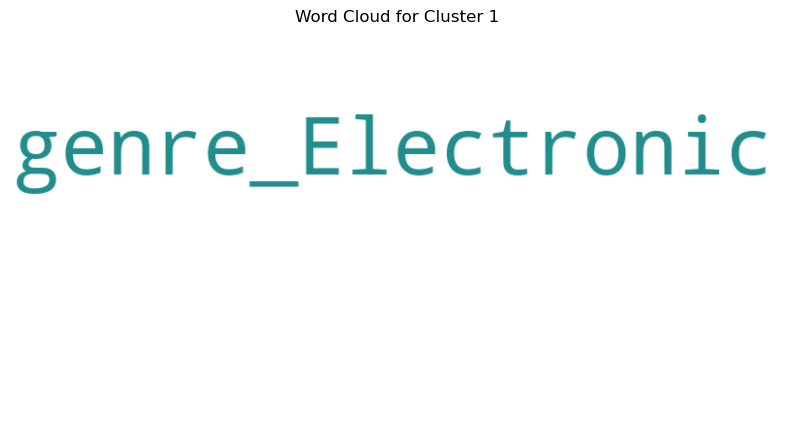

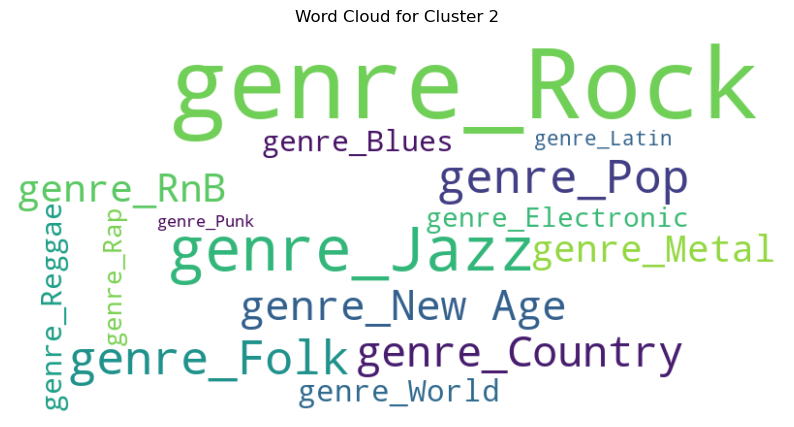

In [6]:
from wordcloud import WordCloud

# Plot word cloud for genre features
for cluster_id in range(len(cluster_characteristics)):
    plt.figure(figsize=(10, 6))
    genre_features = cluster_characteristics.loc[cluster_id, genre_columns]
    
    # Create a dictionary for WordCloud
    genre_dict = genre_features.to_dict()
    
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(genre_dict)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.axis("off")
    plt.show()

##### Songs that represent each cluster

In [16]:
import numpy as np

# Calculate the distance of each song to its cluster centroid
cluster_centroids = kmeans_songs.cluster_centers_  # Centroids of the clusters
song_distances = np.linalg.norm(scaled_songs - cluster_centroids[df_songs['song_cluster']], axis=1)

# Add the distances as a column to df_songs
df_songs['distance_to_centroid'] = song_distances

# For each cluster, find the top N closest songs
N = 5  # Number of representative songs per cluster
representative_songs = []

for cluster_id in range(n_song_clusters):
    # Filter songs belonging to the current cluster
    cluster_songs = df_songs[df_songs['song_cluster'] == cluster_id]
    
    # Sort by distance to centroid
    closest_songs = cluster_songs.nsmallest(N, 'distance_to_centroid')
    
    # Add to the representative songs list
    representative_songs.append(closest_songs[['track_id', 'distance_to_centroid']])

    print(f"\nCluster {cluster_id} Representative Songs:")
    print(closest_songs[['track_id', 'distance_to_centroid', 'name', 'year', 'artist', 'genre']])

# Combine all representative songs into a single DataFrame for further analysis if needed
representative_songs_df = pd.concat(representative_songs, keys=range(n_song_clusters), names=['Cluster ID', 'Index'])

# Save the representative songs to a CSV if desired
representative_songs_df.to_csv("representative_songs.csv", index=True)


Cluster 0 Representative Songs:
                 track_id  distance_to_centroid                   name  year  \
1696   TRRYHJZ128F931451F              1.417919               Conquest  2007   
8686   TRULBIF128F4232AEC              1.420480                 Genius  2003   
17955  TRXWFEP128F92E4AED              1.457797        Mother Superior  2007   
8064   TRMPKTQ12903CAF5C1              1.485859        Radiant Eclipse  2003   
10311  TRFLJDW128F428B0B9              1.494073  I've Just Seen A Face  2007   

                   artist genre  
1696    The White Stripes   NaN  
8686        Kings of Leon   NaN  
17955  Coheed and Cambria   NaN  
8064    Avenged Sevenfold   NaN  
10311        Jim Sturgess   NaN  

Cluster 1 Representative Songs:
                 track_id  distance_to_centroid                 name  year  \
45615  TRAXBBH128F92F9517              1.373543         Shamanic Tea  2005   
28788  TRTTGIP128F147E91F              1.573160               L.E.F.  2006   
8910   TRMTKCK1

##### Plot the clusters

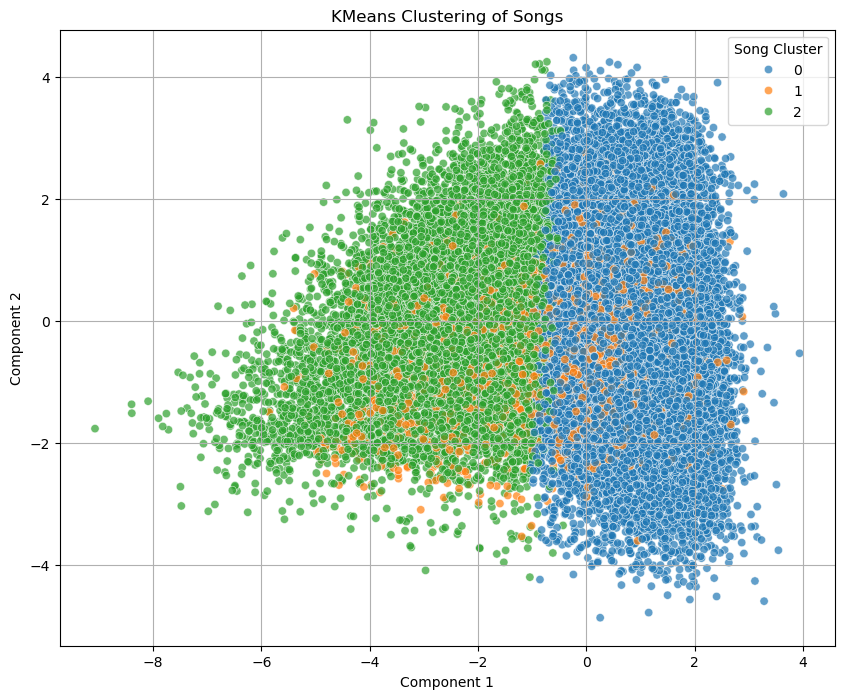

In [8]:
# Apply KMeans clustering to the songs
n_song_clusters = 3  # Choose an appropriate number of clusters
kmeans_songs = KMeans(n_clusters=n_song_clusters, random_state=42)
df_songs['song_cluster'] = kmeans_songs.fit_predict(scaled_songs)

# Reduce to 2D for visualization
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_features = svd.fit_transform(scaled_songs)

# Create a DataFrame for visualization
cluster_vis_df = pd.DataFrame(reduced_features, columns=['Component 1', 'Component 2'])
cluster_vis_df['Cluster'] = df_songs['song_cluster']

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=cluster_vis_df, 
    x='Component 1', 
    y='Component 2', 
    hue='Cluster', 
    palette='tab10', 
    alpha=0.7
)
plt.title('KMeans Clustering of Songs')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Song Cluster', loc='best')
plt.grid(True)
plt.show()

##### Word cloud plots

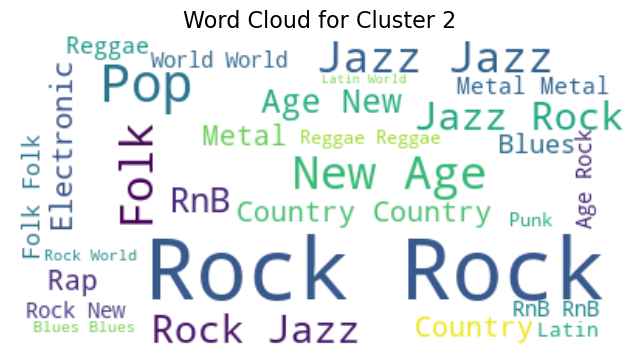

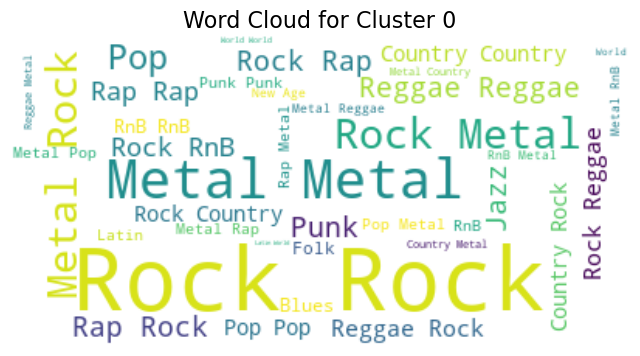

In [15]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Function to generate and display word clouds for a specific cluster
def generate_word_cloud(cluster_id, column):
    # Filter songs in the given cluster
    cluster_songs = df_songs[df_songs['song_cluster'] == cluster_id]
    
    # Combine all text data from the specified column (e.g., 'genre' or 'name')
    text_data = " ".join(cluster_songs[column].dropna())
    
    # Preprocess: Add stopwords if needed
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_data)
    
    # Display the word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Cluster {cluster_id}", fontsize=16)
    plt.axis("off")
    plt.show()

# Example: Generate word cloud for cluster 6
generate_word_cloud(cluster_id=2, column='genre')
generate_word_cloud(cluster_id=0, column='genre')